# Marker-Specific LoD Estimation

Estimates the Limit of Detection (LoD) for each methylation marker using replicate variability.

**Method**: For each marker, fit a power curve (CV = a * e^(-b*x)) to the CV vs signal data, then find where this curve intersects 25% CV.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
df = pd.read_csv('../data/methyl_data_trim.csv')

# Exclude B3GALT6 markers
df = df[~df['mdm'].str.contains('B3GALT6', case=False, na=False)]

print(f"Shape: {df.shape}")
print(f"Patients: {df['Study_Subject_ID'].nunique()}")
print(f"Markers: {df['mdm'].nunique()}")
df.head()

Shape: (20558, 9)
Patients: 200
Markers: 35


,Study_Subject_ID,Study,mdm,log,CANCER_TYPE,cancer_yn,stage,AGE,SEX_D
0,THRCS001-110-1331,V2_Repro_Rep1,ARHGEF4,0.000000,Prostate,1,Stage 2,68,Male
19,THRCS001-110-1331,V2_Repro_Rep1,BARX1,1.925623,Prostate,1,Stage 2,68,Male
20,THRCS001-110-1331,V2_Repro_Rep1,CAPN2,0.000000,Prostate,1,Stage 2,68,Male
21,THRCS001-110-1331,V2_Repro_Rep1,CD1D,2.291757,Prostate,1,Stage 2,68,Male
22,THRCS001-110-1331,V2_Repro_Rep1,CDO1,1.428898,Prostate,1,Stage 2,68,Male


## Calculate Replicate Statistics per Patient-Marker

In [3]:
# Calculate mean, SD, CV for each patient-marker combination
patient_marker_stats = df.groupby(['Study_Subject_ID', 'mdm'])['log'].agg(
    mean='mean',
    std='std',
    cv=lambda x: (x.std() / x.mean() * 100) if x.mean() > 0 else np.nan,
    n_reps='count'
).reset_index()

# Filter to only include cases with positive mean (can't calculate CV for zero)
patient_marker_stats = patient_marker_stats[patient_marker_stats['mean'] > 0]

print(f"Patient-marker combinations with positive signal: {len(patient_marker_stats)}")
patient_marker_stats.head(10)

Patient-marker combinations with positive signal: 5530


,Study_Subject_ID,mdm,mean,std,cv,n_reps
0,THRCS001-101-1160,ARHGEF4,0.192973,0.334239,173.205081,3
1,THRCS001-101-1160,BARX1,1.783338,0.674889,37.844146,3
3,THRCS001-101-1160,CD1D,0.573065,0.992577,173.205081,3
4,THRCS001-101-1160,CDO1,1.649529,0.391819,23.753394,3
9,THRCS001-101-1160,FAM59B_7764,1.235565,1.222814,98.967966,3
11,THRCS001-101-1160,GPRIN1,1.549564,1.390101,89.709180,3
13,THRCS001-101-1160,HOXA1,0.240027,0.415738,173.205081,3
14,THRCS001-101-1160,HOXA9,0.324191,0.561515,173.205081,3
15,THRCS001-101-1160,HOXB2,0.525428,0.910068,173.205081,3
16,THRCS001-101-1160,IFFO1,0.270171,0.467950,173.205081,3


## Visualize CV vs Signal Level by Marker

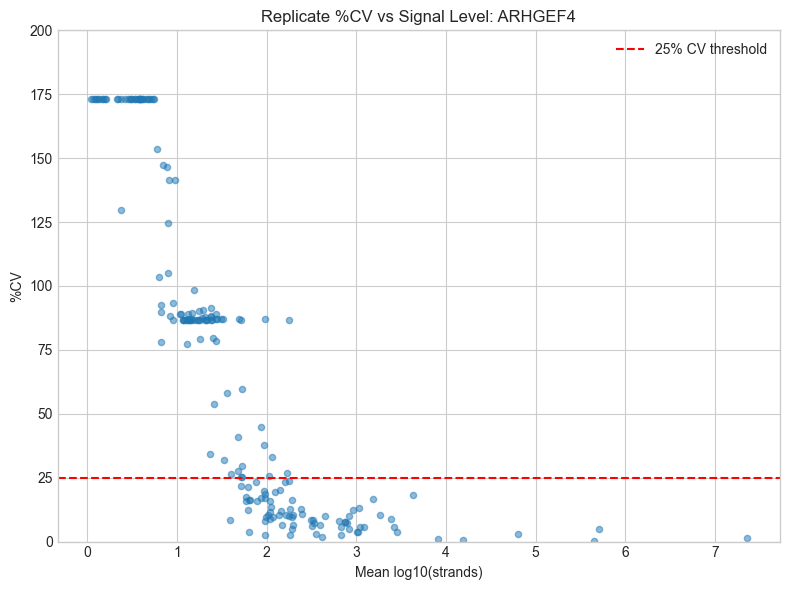

In [9]:
# Plot CV vs mean for one marker
marker = df['mdm'].unique()[0]
subset = patient_marker_stats[patient_marker_stats['mdm'] == marker]

plt.figure(figsize=(8, 6))
plt.scatter(subset['mean'], subset['cv'], alpha=0.5, s=20)
plt.axhline(25, color='red', linestyle='--', label='25% CV threshold')
plt.xlabel('Mean log10(strands)')
plt.ylabel('%CV')
plt.title(f'Replicate %CV vs Signal Level: {marker}')
plt.ylim(0, 200)
plt.legend()
plt.tight_layout()
plt.show()

## Estimate LoD Using Exponential Decay Curve Fit

For each marker, fit CV = a * e^(-b*x) and find where curve intersects 25% CV.

In [10]:
def exp_decay(x, a, b):
    """Exponential decay: y = a * e^(-b*x)"""
    return a * np.exp(-b * x)

def estimate_lod_curve(marker_data, cv_threshold=25):
    """
    Estimate LoD by fitting exponential decay curve to CV vs signal.
    
    Returns the signal level where fitted curve crosses cv_threshold.
    """
    data = marker_data.dropna(subset=['mean', 'cv']).copy()
    data = data[(data['cv'] > 0) & (data['cv'] < 200)]  # Filter outliers
    
    if len(data) < 10:
        return np.nan, None, None
    
    x = data['mean'].values
    y = data['cv'].values
    
    try:
        # Fit exponential decay curve
        popt, _ = curve_fit(exp_decay, x, y, p0=[100, 1], maxfev=5000, bounds=([0, 0], [500, 10]))
        a, b = popt
        
        # Find where curve = cv_threshold: a * e^(-b*x) = threshold
        # x = -ln(threshold/a) / b
        if a > cv_threshold and b > 0:
            lod = -np.log(cv_threshold / a) / b
        else:
            lod = np.nan
            
        return lod, popt, data
    except:
        return np.nan, None, None


# Estimate LoD for all markers
CV_THRESHOLD = 25  # %CV threshold for reliable detection

lod_results = []
lod_fits = {}

for marker in df['mdm'].unique():
    marker_data = patient_marker_stats[patient_marker_stats['mdm'] == marker]
    lod, params, fit_data = estimate_lod_curve(marker_data, cv_threshold=CV_THRESHOLD)
    
    lod_results.append({
        'marker': marker,
        'lod_log10': lod,
        'lod_strands': 10**lod if not np.isnan(lod) else np.nan,
        'n_patients': len(marker_data),
        'median_cv': marker_data['cv'].median(),
        'fit_a': params[0] if params is not None else np.nan,
        'fit_b': params[1] if params is not None else np.nan
    })
    lod_fits[marker] = {'params': params, 'data': fit_data}

lod_df = pd.DataFrame(lod_results).sort_values('lod_log10', ascending=False)
print(f"LoD estimated for {lod_df['lod_log10'].notna().sum()} markers (CV threshold: {CV_THRESHOLD}%)")
lod_df

LoD estimated for 35 markers (CV threshold: 25%)


,marker,lod_log10,lod_strands,n_patients,median_cv,fit_a,fit_b
5,CHST2,3.566226,3683.209252,40,173.205081,209.276367,0.595806
33,ZNF671,3.227527,1688.602592,90,158.625135,214.533047,0.666017
10,FER1L4,3.181349,1518.268619,89,173.205081,252.178242,0.726503
2,CAPN2,3.091293,1233.937841,116,146.814322,219.519353,0.702801
32,ZNF569,3.055156,1135.419219,20,115.859391,223.719426,0.717317
22,QKI,3.034805,1083.439398,72,141.421356,209.069504,0.699811
31,VAV3,2.956979,905.689499,29,40.683153,189.836439,0.685594
18,NTRK3,2.822984,665.248110,183,86.753481,193.282034,0.724508
24,SFMBT2_897,2.747318,558.879422,42,87.821945,249.383917,0.837223
7,EMX1,2.675268,473.443078,152,88.030777,241.263863,0.847398


## Precision Profiles with Fitted Curves

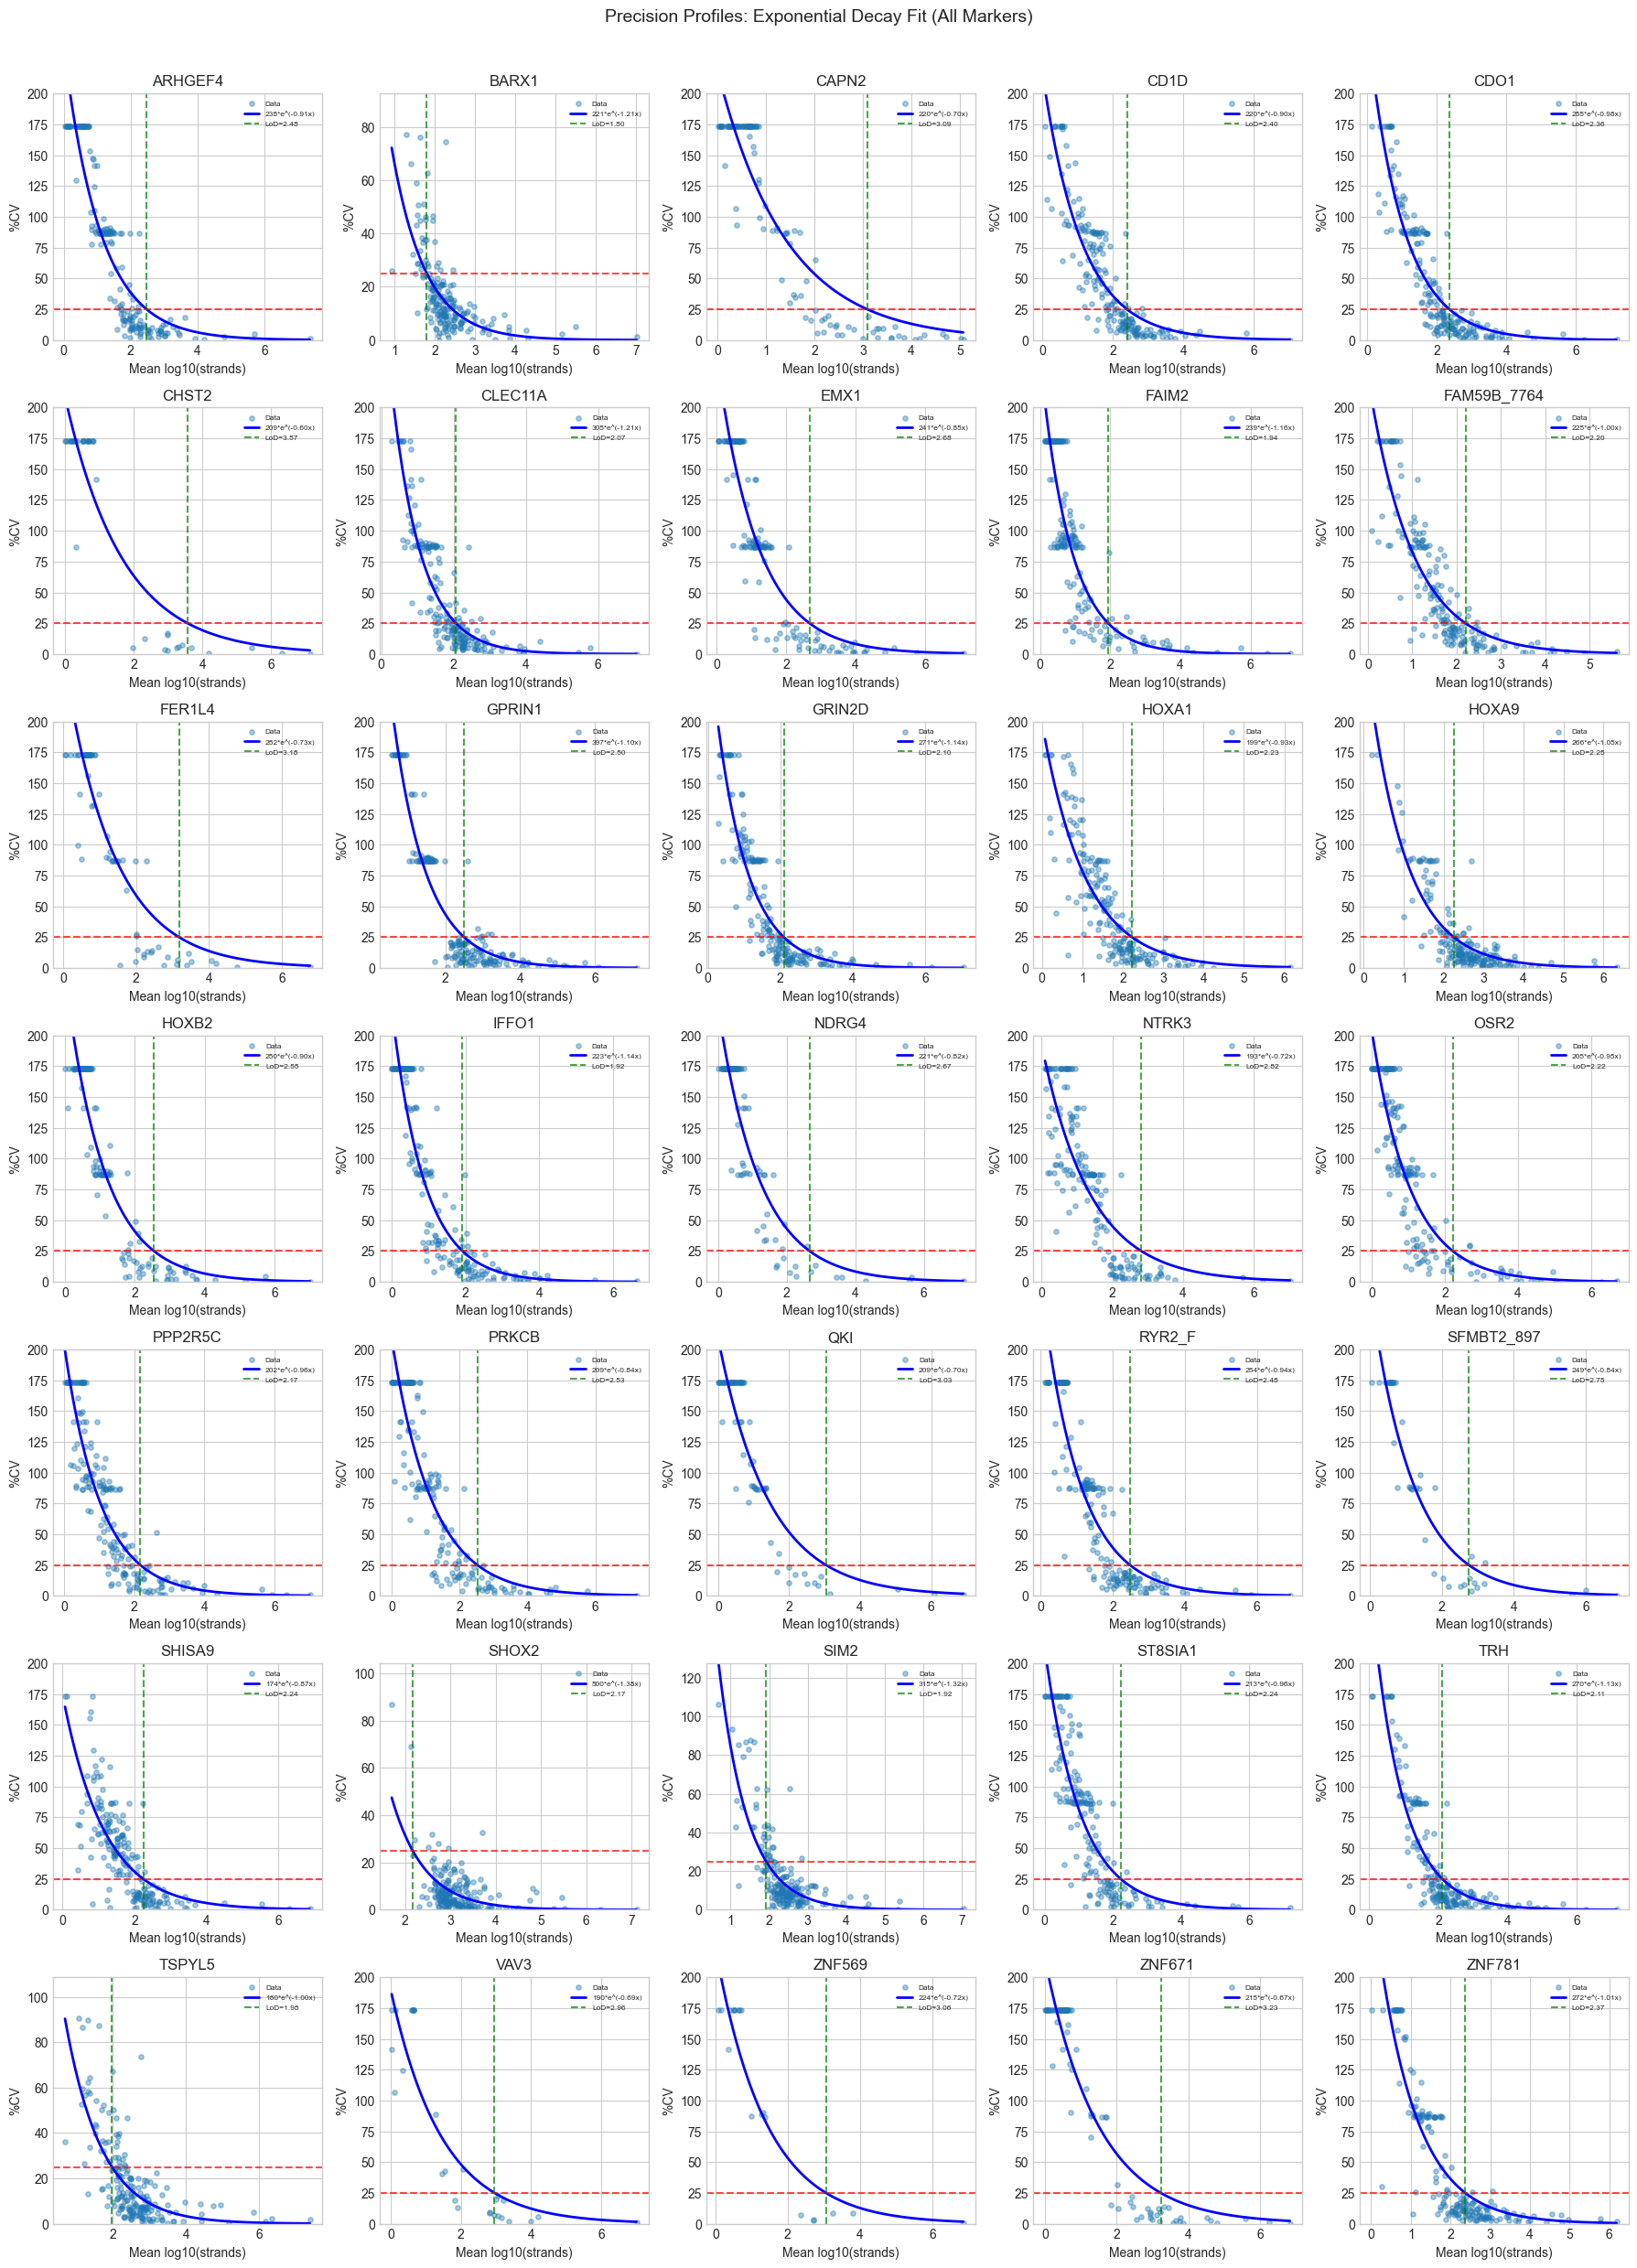

In [ ]:
# Plot precision profiles with fitted curves for ALL markers
all_markers = sorted(lod_df.dropna(subset=['lod_log10'])['marker'].tolist())
n_markers = len(all_markers)
n_cols = 5
n_rows = int(np.ceil(n_markers / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 3.5))
axes = axes.flatten()

for i, marker in enumerate(all_markers):
    if marker not in lod_fits or lod_fits[marker]['params'] is None:
        continue
    
    params = lod_fits[marker]['params']
    data = lod_fits[marker]['data']
    lod = lod_df[lod_df['marker'] == marker]['lod_log10'].values[0]
    
    # Scatter plot of raw data
    axes[i].scatter(data['mean'], data['cv'], alpha=0.4, s=15, label='Data')
    
    # Plot fitted curve
    x_fit = np.linspace(data['mean'].min(), data['mean'].max(), 100)
    y_fit = exp_decay(x_fit, *params)
    axes[i].plot(x_fit, y_fit, 'b-', linewidth=2, label=f'{params[0]:.0f}*e^(-{params[1]:.2f}x)')
    
    # Threshold and LoD lines
    axes[i].axhline(CV_THRESHOLD, color='red', linestyle='--', alpha=0.7)
    if not np.isnan(lod):
        axes[i].axvline(lod, color='green', linestyle='--', alpha=0.7, label=f'LoD={lod:.2f}')
    
    axes[i].set_xlabel('Mean log10(strands)')
    axes[i].set_ylabel('%CV')
    axes[i].set_title(marker)
    axes[i].legend(fontsize=6, loc='upper right')
    axes[i].set_ylim(0, min(200, data['cv'].max() * 1.2))

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Precision Profiles: Exponential Decay Fit (All Markers)', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()